In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import config as c
from assim_tools.obs import *

import models.topaz.v5 as tp5
import dataset.prep_obs.insitu as insitu

from assim_tools.conversion import *

In [4]:
c.time = '202310230000'

In [17]:
for i, j in zip(range(10), range(5)):
    print(i, j)

0 0
1 1
2 2
3 3
4 4


In [5]:
path = c.work_dir + '/forecast/'+c.time+'/topaz.v5'
grid = tp5.read_grid(path)
grid.dst_grid = c.grid
mask = tp5.read_mask(path, grid)


In [16]:
grid.convert(tp5.z_coords(path, grid, member=11, k=1, units='m'))

array([[        nan,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [        nan,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [        nan,         nan,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.18501212, -1.13939005, -1.09388944, ...,         nan,
                nan,         nan],
       [-0.65566   , -0.61002763, -0.56451675, ...,         nan,
                nan,         nan],
       [-0.1261843 , -0.08054162, -0.03502047, ...,         nan,
                nan,         nan]])

In [3]:
obs_info = parse_obs_info(c)

In [4]:
obs_info['records'][1]

{'name': 'ocean_saln',
 'source': 'prep_obs.insitu',
 'model': 'topaz.v5',
 'dtype': 'float',
 'is_vector': False,
 'units': 'psu',
 'z_units': 'm',
 'pos': 6656,
 'err': {'type': 'normal',
  'std': 0.1,
  'hcorr': 0.0,
  'vcorr': 0.0,
  'tcorr': 0.0,
  'cross_corr': array([0., 1.])},
 'hroi': 200000.0,
 'vroi': inf,
 'troi': inf,
 'impact_on_state': array([0. , 0.5, 1. ]),
 'obs': array([27.000002, 27.010002, 28.2     , ..., 34.851   , 34.882   ,
        34.904003], dtype=float32),
 'x': array([-1222948.1827887 , -1222948.1827887 , -1222948.1827887 , ...,
          944417.54588382,   944417.54588382,   944417.54588382]),
 'y': array([-196431.90218819, -196431.90218819, -196431.90218819, ...,
         -80837.09679508,  -80837.09679508,  -80837.09679508]),
 'z': array([  -2.     ,  -10.     ,  -20.     , ..., -131.55211, -145.93106,
        -162.04364], dtype=float32),
 'time': array([1085256.55      , 1085256.55      , 1085256.55      , ...,
        1085264.98333333, 1085264.98333333, 

In [ ]:
obs_seq_file = '/cluster/work/users/yingyue/exp1/analysis/202310230000/prior_obs.bin'

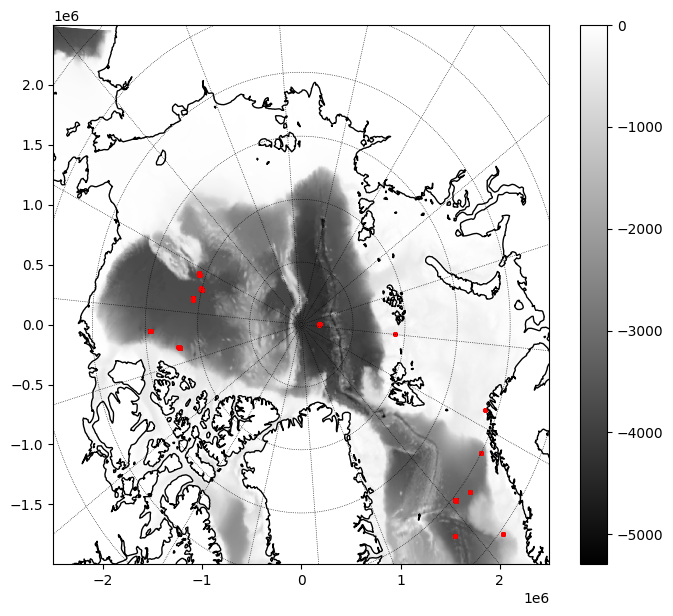

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

im = c.grid.plot_field(ax, c.z[-1,...], cmap='gist_gray')
plt.colorbar(im)

c.grid.plot_land(ax)

obs_rec = obs_info['records'][1]
ax.scatter(obs_rec['x'], obs_rec['y'], 20, color='r', marker='.')


In [5]:
path = c.work_dir + '/forecast/'+c.time+'/topaz.v5'
grid = tp5.read_grid(path)
mask = tp5.read_mask(path, grid)

In [6]:
ONEM = 9806.
nz = 50
dz = np.zeros((nz, grid.ny, grid.nx))
for k in range(nz):
    dz[k, ...] = tp5.read_var(path, grid, name='ocean_layer_thick', member=10, k=tp5.levels[k]) / ONEM
z = np.cumsum(-dz, axis=0)
z[np.isnan(z)] = 0

In [7]:
var = np.zeros((nz, grid.ny, grid.nx))
for k in range(nz):
    var[k,...] = tp5.read_var(path, grid, name='ocean_temp', member=10, k=tp5.levels[k])

In [8]:
datapath = c.data_dir + '/prep_obs.insitu'

obs = insitu.read_obs(datapath, grid, mask, z, name='ocean_temp', time=datetime(2023, 10, 22))

In [9]:
j = 400
dy = 100000 ##meter
inds = np.where(np.abs(np.array(obs['y'])-grid.y[j,0]) < dy)

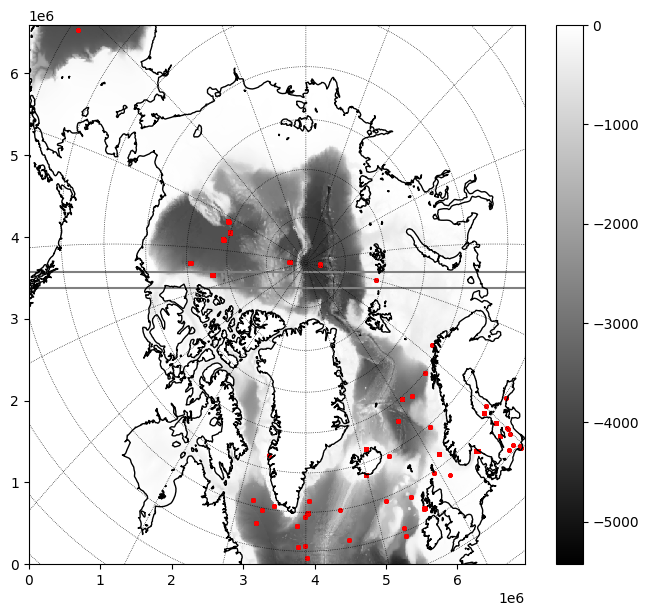

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

im = grid.plot_field(ax, z[-1,...], cmap='gist_gray')
plt.colorbar(im)

grid.plot_land(ax)

ax.scatter(obs['x'], obs['y'], 20, color='r', marker='.')

ax.plot(grid.x[j,:], grid.y[j,:]+dy, color='gray')
ax.plot(grid.x[j,:], grid.y[j,:]-dy, color='gray')

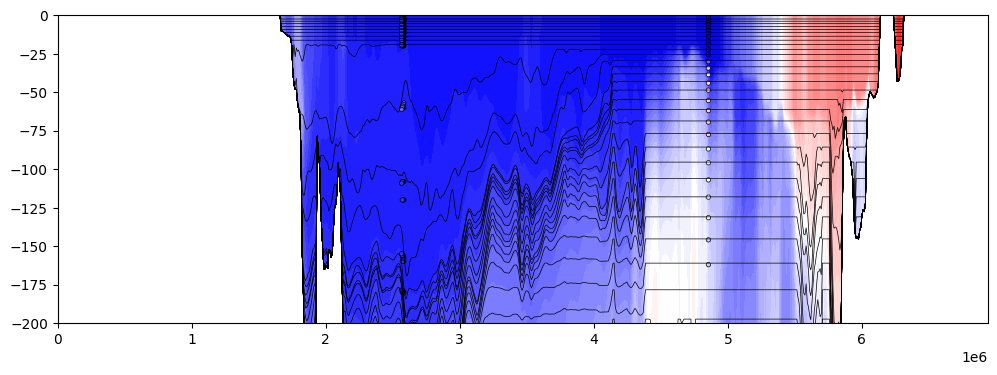

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

x, k = np.meshgrid(grid.x[j, :], np.arange(nz))

vmin = -2
vmax = 8
cmap = [plt.cm.bwr(x) for x in np.linspace(0, 1, round(vmax-vmin)+1)]
ax.contourf(x, z[:, j, :], var[:, j, :], np.arange(vmin, vmax, (vmax-vmin)/40), cmap=plt.cm.bwr)

##show isopycnal grid
ax.contour(x, z[:, j, :], k, np.arange(0,nz+1,1)-1e-10, colors='k', linewidths=0.5)

#ax.set_xlim(3e6, 5e6)
ax.set_ylim(-200, 0)

##show obs value
vout = np.array(obs['obs'])[inds]
cind = np.maximum(np.minimum(np.round(vout-vmin), int(np.round(vmax-vmin))), 0).astype(int)
ax.scatter(np.array(obs['x'])[inds], np.array(obs['z'])[inds], 10, color=np.array(cmap)[cind, 0:3], edgecolor='k', linewidth=0.5)
